# 1. Data Cleaning

Import data and look for missing values and outliers.

Data Observations:

- Most sequences have random sections of missing values
- Both ends of the sequences have ragged alignment

Cleaning Approach:

- For positions with <5% invalid symbols ('-','.','N'), substitute the most common nucleotide value.
- For positions with >5% invalid symbols, omit from analysis.

---


Import Packages


In [15]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import os

os.makedirs("../plots", exist_ok=True)

Read FASTA file.


In [16]:
check_performance = True
raw_seq_file = "../data/Modified_Sequences.fasta"

file = open(raw_seq_file, "r")
lines = file.readlines()
file.close()

Parse FASTA file. Convert ASCII characters to int16 values.


In [17]:
def parse_sequences(rows):
    seq_names = np.array([name.strip() for name in rows[::2]])
    seqs = np.array([list(mers.strip()) for mers in rows[1::2]], dtype="S1")
    seqs = np.array(seqs).view(np.int8)
    return seqs, seq_names


sequences, _ = parse_sequences(lines)
print(sequences.shape)
sequences[:5, 100:110]

(400, 34044)


array([[45, 45, 45, 45, 45, 45, 45, 45, 45, 45],
       [45, 45, 45, 45, 45, 45, 45, 45, 45, 45],
       [84, 84, 67, 71, 65, 84, 67, 84, 67, 84],
       [84, 84, 67, 71, 65, 84, 67, 84, 67, 84],
       [45, 45, 45, 45, 45, 45, 45, 45, 45, 45]], dtype=int8)

Look at frequency of the various symbols and nucleotides.


In [18]:
unique, frequency = np.unique(sequences, return_counts=True)
print(unique)
print([chr(c) for c in list(unique)])
print(frequency)

[45 46 65 67 71 78 84]
['-', '.', 'A', 'C', 'G', 'N', 'T']
[  52414 6581600 2023047 1360967 1355041   68929 2175602]


Visualize Sequences.

See saved image for more detail.


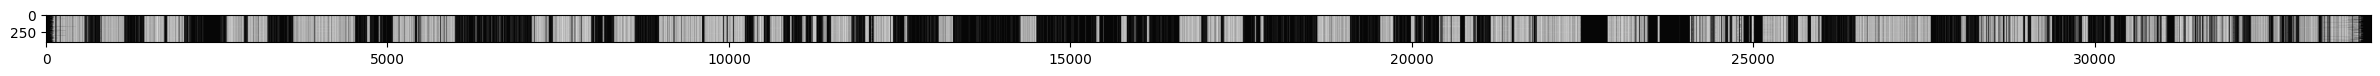

In [19]:
plt.figure(figsize=(30, 30))
plt.imshow(sequences, cmap="gray")
plt.imsave("../plots/sequences.png", sequences, cmap="gray")

Only look at initial 500 base-pairs.


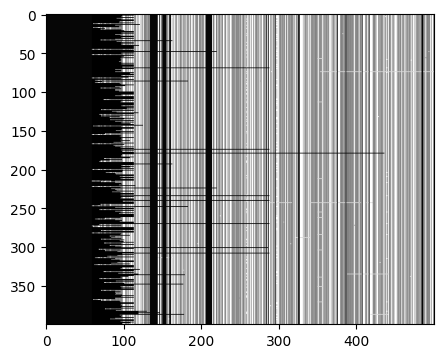

In [20]:
plt.figure(figsize=(5, 5))
plt.imshow(sequences[:, :500], cmap="gray")
plt.imsave("../plots/sequences_head.png", sequences[:, :500], cmap="gray")

Only look at last 500 base pairs.


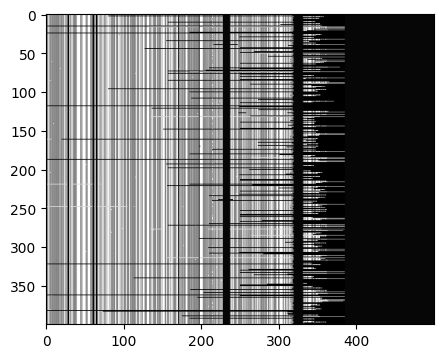

In [21]:
plt.figure(figsize=(5, 5))
plt.imshow(sequences[:, -500:], cmap="gray")
plt.imsave("../plots/sequences_tail.png", sequences[:, -500:], cmap="gray")

Find number of invalid characters for each position


In [22]:
n, m = sequences.shape
invalid_chars = [45, 46, 78]  # 45='-', 46='.', 78='N"
valid_threshold = 0.25

clean_seqs = sequences.copy()
invalid_counts = np.isin(clean_seqs, invalid_chars)
invalid_ratios = np.sum(invalid_counts, axis=0) / n

Find most common character for each position


In [23]:
mode_result = stats.mode(sequences, axis=0)
most_common_values = mode_result.mode
most_common_values = np.tile(most_common_values, (n, 1))
print(most_common_values.shape)

(400, 34044)


Impute most common valid character for invalid characters.

Drop positions that exceed the threshold for invalid characters.


In [24]:
clean_seqs[invalid_counts] = most_common_values[invalid_counts]
keep_mask = invalid_ratios < valid_threshold
clean_seqs = clean_seqs[:, keep_mask]
print(clean_seqs.shape)
clean_seqs[:5, :10]

(400, 17463)


array([[65, 71, 65, 84, 67, 84, 71, 84, 84, 67],
       [65, 71, 65, 84, 67, 84, 71, 84, 84, 67],
       [65, 71, 65, 84, 67, 84, 71, 84, 84, 67],
       [65, 71, 65, 84, 67, 84, 71, 84, 84, 67],
       [65, 71, 65, 84, 67, 84, 71, 84, 84, 67]], dtype=int8)

Review what percent of values are imputed for each sequence.


0.09271030178090821

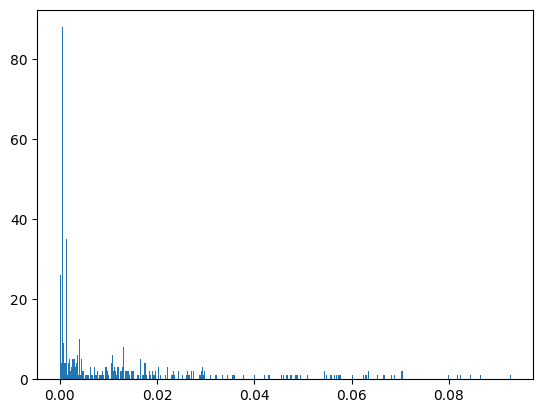

In [25]:
clean_invalid_counts = invalid_counts[:, keep_mask]
invalid_count_per_seq = np.sum(clean_invalid_counts, axis=1)
invalid_ratio_per_seq = invalid_count_per_seq / clean_invalid_counts.shape[1]

_ = plt.hist(invalid_ratio_per_seq, bins=400)
max(invalid_ratio_per_seq)

Check which symbols and associated frequency, post cleaning.


In [26]:
unique, frequency = np.unique(clean_seqs, return_counts=True)
print(clean_seqs.shape)
print(unique)
print([chr(c) for c in list(unique)])
print(frequency)

(400, 17463)
[65 67 71 84]
['A', 'C', 'G', 'T']
[2044214 1373114 1369917 2197955]


Visualize Sequences, post-cleaning


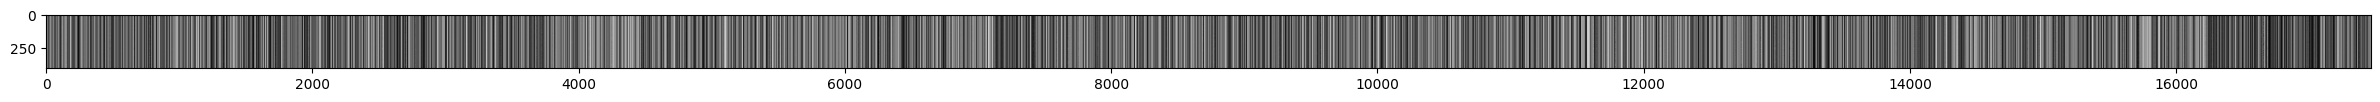

In [27]:
plt.figure(figsize=(30, 30))
plt.imshow(clean_seqs, cmap="gray")
plt.imsave("../plots/sequences_clean.png", clean_seqs, cmap="gray")

Only look at first 500 base pairs, post-cleaning.


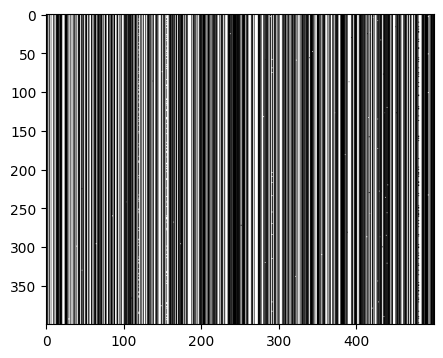

In [28]:
plt.figure(figsize=(5, 5))
plt.imshow(clean_seqs[:, :500], cmap="gray")
plt.imsave("../plots/sequences_clean_head.png", clean_seqs[:, :500], cmap="gray")

Only look at last 500 base pairs, post-cleaning.


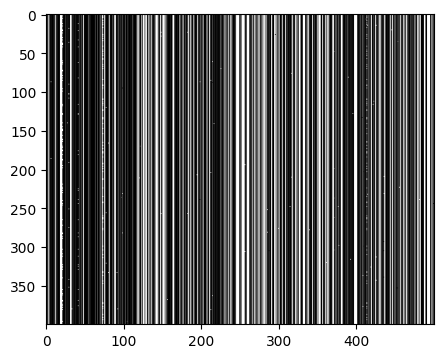

In [29]:
plt.figure(figsize=(5, 5))
plt.imshow(clean_seqs[:, -500:], cmap="gray")
plt.imsave("../plots/sequences_clean_tail.png", clean_seqs[:, -500:], cmap="gray")

Calculate Entropy across the sequences

$$H(x) = -\sum_{i=1}^n P(x_i) \log_4 P(x_i)$$

Note that I'm using log base 4 to calculate entropy for nucleotides versus the typical log base 2 for bits.


In [30]:
def component_entropy(p):
    return -p * np.log(prob) / np.log(4)

In [31]:
prob = np.full(100, 0.5)
component_entropy(prob)

array([0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25,
       0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25,
       0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25,
       0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25,
       0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25,
       0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25,
       0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25,
       0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25,
       0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25,
       0.25])

In [32]:
n, m = clean_seqs.shape
chars = [65, 67, 71, 84, 46]  # 65='A', 67='C', 71='G', 84='T', 46='.',

# Get counts
partial_counts = np.array([(clean_seqs == char).sum(axis=0) for char in chars]).T
counts = partial_counts.sum(axis=1)

# Calculate probabilities
probabilities = partial_counts / counts[:, None]


# Calculate partial entropy
def component_entropy(p):
    # Apply entropy formula only for non-zero probabilities, avoid log(0)
    return np.where(p > 0, -p * np.log(p) / np.log(4), 0.0)


partial_entropy = component_entropy(probabilities)
entropy = np.sum(partial_entropy, axis=1)
entropy[10000:10010]

C:\Users\Josh.Meehl\AppData\Local\Temp\ipykernel_37924\2821021543.py:15: RuntimeWarning: divide by zero encountered in log
  return np.where(p > 0, -p * np.log(p) / np.log(4), 0.0)
C:\Users\Josh.Meehl\AppData\Local\Temp\ipykernel_37924\2821021543.py:15: RuntimeWarning: invalid value encountered in multiply
  return np.where(p > 0, -p * np.log(p) / np.log(4), 0.0)


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [33]:
entropy2 = entropy.copy()

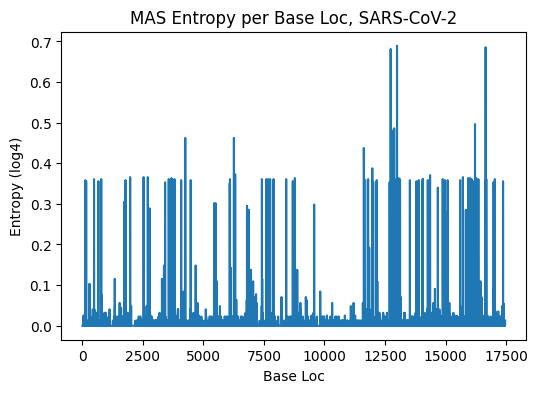

In [34]:
plt.rcParams["figure.figsize"] = [6, 4]
plt.plot(entropy)
plt.title("MAS Entropy per Base Loc, SARS-CoV-2")
plt.xlabel("Base Loc")
plt.ylabel("Entropy (log4)")
plt.show()

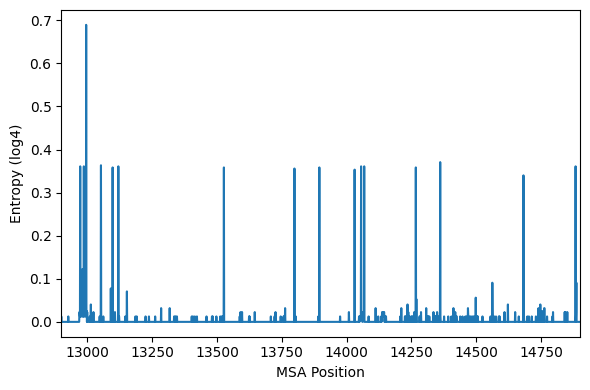

In [35]:
a = 12900
b = a + 2000

plt.rcParams["figure.figsize"] = [6, 4]
plt.plot(entropy)
# plt.title(f"Entropy per Position for SARS-CoV-2 MSA")
plt.xlim(a, b)
plt.xlabel("MSA Position")
plt.ylabel("Entropy (log4)")
plt.tight_layout()
plt.savefig("../plots/entropy.png")
plt.show()

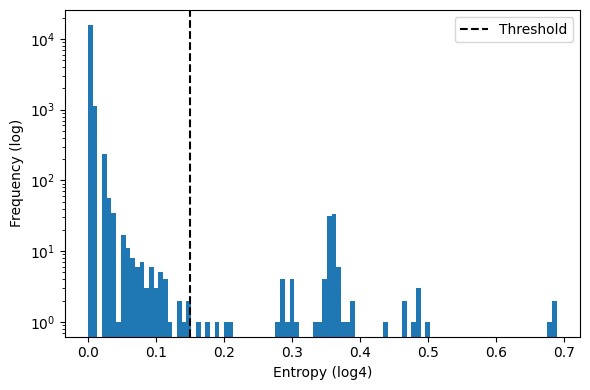

In [36]:
plt.hist(entropy, bins=100, log=True)
plt.axvline(0.15, color="k", linestyle="--", label="Threshold")
plt.xlabel("Entropy (log4)")
plt.ylabel("Frequency (log)")
plt.legend()
plt.tight_layout()
plt.savefig("../plots/entropy_hist.png")
plt.show()

In [37]:
for a in range(clean_seqs.shape[1]):
    mer = clean_seqs[:, a]
    ent = entropy[a]
    unique, frequency = np.unique(mer, return_counts=True)
    frequency = frequency.min() / frequency.sum()
    if frequency > 0.045 and frequency < 0.055:
        print(f"Position {a}: {len(unique)} {frequency} {ent}")

Position 3370: 2 0.0525 0.1484616619558652
Position 4678: 2 0.0525 0.1484616619558652
Position 6120: 2 0.05 0.1431984785579781
Position 6956: 2 0.0475 0.13784034339938256
Position 8874: 2 0.0475 0.13784034339938256


Trim sequence to only positions with varying values

To reduce noise due to random mutation and reading errors, at least 5% of sequences need to have a given nucleotide for each position.


In [38]:
trim_seqs = clean_seqs[:, entropy > 0.145]
trim_seqs.shape

(400, 110)

Visualize Sequences, post-trimming


(400, 17463) (400, 110)


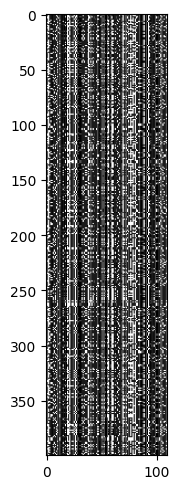

In [39]:
print(clean_seqs.shape, trim_seqs.shape)

plt.figure(figsize=(2, 5))
plt.imshow(trim_seqs, cmap="gray")
plt.tight_layout()
plt.savefig(rf"../plots/sequences_trim.png")
plt.show()

Save cleaned data to file.


In [40]:
trim_seqs

array([[71, 84, 84, ..., 67, 84, 84],
       [71, 84, 84, ..., 67, 84, 84],
       [71, 71, 84, ..., 67, 71, 71],
       ...,
       [71, 71, 84, ..., 67, 71, 71],
       [71, 71, 67, ..., 67, 71, 71],
       [71, 71, 84, ..., 67, 71, 71]], dtype=int8)

In [41]:
save_file = "../data/trim_seqs.npy"
np.save(save_file, trim_seqs)

### Cleaning, Final Thoughts:

The sequences look much cleaner now!
